In [1]:
%cd nanoGPT

/home/app/repos/selfishTokens_2/nanoGPT


/usr/local/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import torch
device='cpu'

from model import GPTConfig, GPT

def get_model(out_dir='out/baseline/'):
    # init from a model saved in a specific directory
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)

    model.eval()
    return model

In [3]:
models = {
    'baseline': get_model('out/baseline'),
    'margin_2': get_model('out/proposed_margin_2')
}

number of parameters: 0.80M
number of parameters: 0.80M


/tmp/ipykernel_51075/207514028.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


In [4]:
import numpy as np

block_size = models['baseline'].config.block_size
dataset = 'shakespeare_char'
batch_size = 1
device_type = 'cpu'

data_dir = os.path.join('data', dataset)
def get_batch(split, language='random', vocab_size=65):
    # We recreate np.memmap every batch to avoid a memory leak
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
    
    ix = torch.randint(len(data) - block_size, (batch_size,))
    
    x_list = []
    y_list = []
    
    for i in ix:
        # Determine language for each individual sample if 'random' is specified
        current_language = language
        if language == 'random':
            current_language = 'big' if torch.rand(1).item() < big_language_prob else 'small'
        
        # Get the input and target sequences
        x_sample = torch.from_numpy((data[i:i + block_size]).astype(np.int64))
        y_sample = torch.from_numpy((data[i + 1:i + 1 + block_size]).astype(np.int64))
        
        # Modify x and y if the language is 'small'
        if current_language == 'small':
            x_sample = x_sample + vocab_size
            y_sample = y_sample + vocab_size
        
        # Append to lists
        x_list.append(x_sample)
        y_list.append(y_sample)
    
    # Stack the lists into tensors
    x = torch.stack(x_list)
    y = torch.stack(y_list)
    
    if device_type == 'cuda':
        # Pin arrays x, y for asynchronous GPU transfer
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [5]:
lang = 'big'
data = get_batch('val', lang)

In [6]:
import pickle

meta_path = 'data/shakespeare_char/meta.pkl'
print(f"Loading meta from {meta_path}...")
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
# TODO want to make this more general to arbitrary encoder/decoder schemes
stoi, itos = meta['stoi'], meta['itos']
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

Loading meta from data/shakespeare_char/meta.pkl...


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

In [8]:
logits = {
    name: model(*data)[0].detach().numpy() for name,model in models.items()
}

In [11]:
if lang == 'big':
    ps = {
        name: softmax(l[0,-1,:65]) for name, l in logits.items()
    }
else:
    ps = {
        name: softmax(l[0,-1,65:]) for name, l in logits.items()
    }

ps_sorted = {
    name: list(p[np.argsort(-np.array(ps['baseline']))]) for name, p in ps.items()
}

# ps_sorted = {
#     name: sorted(p, reverse=True) for name, p in ps.items()
# }

if lang == 'big':
    gt_values = {
        name: p[data[1][0, -1].item()-65] for name, p in ps.items()
    }
else:
    gt_values = {
        name: p[data[1][0, -1].item()-65] for name, p in ps.items()
    }

gt_ranks = {
    name: ps_sorted[name].index(value) for name, value in gt_values.items()
}

In [12]:
def update_x(x):
    if x == ' ':
        return '\\s'
    elif x == '\n':
        return '\\n'
    return x

decoded_tokens = np.argsort(-np.array(ps['baseline']))
decoded_tokens = list(decode(decoded_tokens))

decoded_tokens = [update_x(x) for x in decoded_tokens]

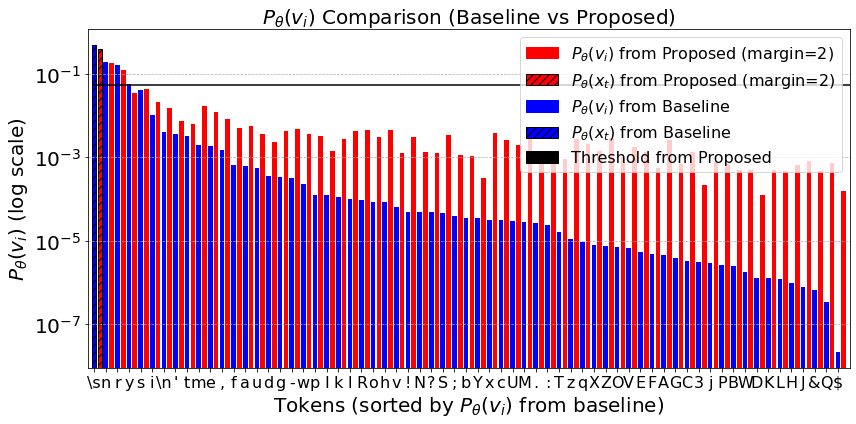

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

bars = []
bar_colors = []
bar_hatches = []  # To store hatch patterns for ground truth
bar_edges = []  # To store edge colors for ground truth

for i in range(65):
    # Add baseline bar
    bars.append(ps_sorted['baseline'][i])
    if i == gt_ranks['baseline']:
        bar_colors.append('blue')  # Keep the same color
        bar_hatches.append('///')  # Add hatch pattern for ground truth
        bar_edges.append('black')  # Black edge for ground truth
    else:
        bar_colors.append('blue')  # Regular baseline color
        bar_hatches.append('')  # No hatch for non-ground truth
        bar_edges.append('none')  # No edge for non-ground truth

    # Add margin_2 bar
    bars.append(ps_sorted['margin_2'][i])
    if i == gt_ranks['margin_2']:
        bar_colors.append('red')  # Keep the same color
        bar_hatches.append('///')  # Add hatch pattern for ground truth
        bar_edges.append('black')  # Black edge for ground truth
    else:
        bar_colors.append('red')  # Regular margin_2 color
        bar_hatches.append('')  # No hatch for non-ground truth
        bar_edges.append('none')  # No edge for non-ground truth

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the bars with hatch patterns and edge colors for ground truth
for idx, (bar, color, hatch, edge) in enumerate(zip(bars, bar_colors, bar_hatches, bar_edges)):
    ax.bar(idx, bar, color=color, hatch=hatch, edgecolor=edge)

# Plot the threshold line
th = gt_values['margin_2'] * np.exp(-2)
plt.plot([0, 130], [th, th], label='threshold', color='black')


plt.title(r'$P_{\theta}(v_i)$ Comparison (Baseline vs Proposed)', fontsize=20)
plt.xlabel(r'Tokens (sorted by $P_{\theta}(v_i)$ from baseline)', fontsize=20)
plt.ylabel(r'$P_{\theta}(v_i)$ (log scale)', fontsize=20)

# Define legend patches
red_patch = mpatches.Patch(color='red', label=r'$P_{\theta}(v_i)$ from Proposed (margin=2)')
blue_patch = mpatches.Patch(color='blue', label=r'$P_{\theta}(v_i)$ from Baseline')
black_patch = mpatches.Patch(color='black', label='Threshold from Proposed')
# Ground truth labels for ornamented bars
gt_baseline_patch = mpatches.Patch(facecolor='blue', hatch='///', edgecolor='black', label=r'$P_{\theta}(x_t)$ from Baseline')
gt_margin_patch = mpatches.Patch(facecolor='red', hatch='///', edgecolor='black', label=r'$P_{\theta}(x_t)$ from Proposed (margin=2)')

# Add all the patches to the legend
plt.legend(handles=[red_patch, gt_margin_patch, blue_patch, gt_baseline_patch, black_patch], fontsize=16)

# Use log scale for y-axis
plt.yscale('log')

plt.xticks(ticks=np.arange(len(decoded_tokens))*2, labels=decoded_tokens, fontsize=16)
plt.yticks(fontsize=20)

# Add grid and set x-axis limits
plt.grid(True, which='major', linestyle='--', linewidth=0.7, axis='y')
plt.xlim((-1, 130))

plt.tight_layout()
# Save the plot as a PDF file
plt.savefig("../assets/long_tail_example.pdf", format="pdf")

# Display the plot
plt.show()


In [122]:
decode(data[0][0].numpy()-65)

'\n\nGREMIO:\nTwo thousand ducats by the year of land!\nMy land amoun'